### TODO
- optimize hyper params (more layers, more neurons, different lr etc, more epochs)
- add dropout for regularization (note that we cannot directly then compare training and val loss during training, as dropout is not active during validation)
- display the confusion matrix
- based on confusion matrix show the numbers that are close to each other, display their spectograms

In [121]:
import torch
import numpy as np
from torch import nn
from torch.utils.data import DataLoader
from tqdm import tqdm
import torch.nn.functional as F

In [122]:
# if possible we want to use the GPU for training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [123]:
# load the data into tensors, target should be an integer
X = torch.tensor(np.load('x_digits.npy'), dtype=torch.float32)
y = torch.tensor(np.load('y_digits.npy'), dtype=torch.int64)


In [124]:
X.shape, y.shape

(torch.Size([35631, 129, 71]), torch.Size([35631]))

In [125]:
# zip the data and target together
zip_data = list(zip(X, y))

In [126]:
# because the data is ordered (all examples of 0, then all examples of 1, etc.), we need to shuffle it, so our batches contain all classes
# we shuffle the pairs of observations and targets and then split the data into training, validation and test sets (64%, 16%, 20%)
subsets = torch.utils.data.random_split(zip_data, [0.64, 0.16, 0.2])

In [127]:
batch_size = 64

In [128]:
# create dataloaders for the training, validation and test set
# in training we want to shuffle the data each epoch, not to overfit to the order of the data
train_dataloader = DataLoader(subsets[0], batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(subsets[1], batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(subsets[2], batch_size=batch_size, shuffle=False)



In [129]:
# we define our fully connected neural network
# we use batch normalization to stabilize training
# we also use it before the first layer to normalize the input data
# becaues the spectogram is 2D, we flatten it to a 1D tensor
# we use ReLU as activation function
# we use kaiming (He) initialization for the weights in linear layers, because we use ReLU
class FCNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()

        self.sequent = nn.Sequential(
            nn.BatchNorm1d(129*71), # kinda scaling
            nn.Linear(129*71, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Linear(64, 10)
        )

        self.sequent.apply(self.__init_weights)
    
    def forward(self, x):
        x = self.flatten(x)
        x = self.sequent(x)
        return x
    
    def __init_weights(self, m):
        if isinstance(m, nn.Linear):
            torch.nn.init.kaiming_normal_(m.weight)

In [130]:
# if possible transfer the model to the GPU
model = FCNet()
model = model.to(device)

In [131]:
n_train = len(subsets[0].indices)
n_val = len(subsets[1].indices)
n_test = len(subsets[2].indices)

In [132]:
# we use the AdamW optimizer and reduce the learning rate on plateau after 5 epochs without improvement
optimizer = torch.optim.AdamW(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.5)

# we train the model for 30 epochs
min_val_loss = float('inf')
early_stop = 0

for i in tqdm(range(30)):


    # we put the model in training mode (important for batch normalization)
    model.train()
    acc = 0
    total_loss = 0
    # we do forward and backward pass for each batch until we have seen all training data
    # we calculate the accuracy and loss for the training data
    for X_batch, y_batch in train_dataloader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        y_pred = model(X_batch)
        loss = F.cross_entropy(y_pred, y_batch)
        total_loss += loss
        acc += (torch.argmax(y_pred, dim=1) == y_batch).sum().item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # because we were getting loss and accuracy per batch, we need to average it
    acc /= n_train
    total_loss /= len(train_dataloader)

    model.eval()
    val_loss = 0
    val_acc = 0
    # for validation we don't need to calculate gradients
    with torch.no_grad():
        for X_batch, y_batch in val_dataloader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_pred = model(X_batch)
            val_loss += F.cross_entropy(y_pred, y_batch).item()
            # we calculate the accuracy for the validation data
            # we check the number of cases where the class with highest predicted probability is the same as the target class
            # .item() extracts the value from the tensor
            val_acc += (torch.argmax(y_pred, dim=1) == y_batch).sum().item()
    
    val_loss /= len(val_dataloader)

    print(f"Epoch {i+1} - Accuracy: {acc:.4f} - Loss: {total_loss:.4f} - Val Loss: {val_loss:.4f}, Val accuracy: {val_acc/n_val:.4f}")
    # we implement early stopping, if the validation loss doesn't improve for 10 epochs, we stop training
    if val_loss < min_val_loss:
        min_val_loss = val_loss
        early_stop = 0
    else:
        early_stop += 1
        if early_stop == 10:
            break

    # we reduce the learning rate if the validation loss doesn't improve for 5 epochs
    scheduler.step(val_loss)
        

  0%|          | 0/30 [00:00<?, ?it/s]

  3%|▎         | 1/30 [00:06<03:20,  6.91s/it]

Epoch 1 - Accuracy: 0.4925 - Loss: 1.4199 - Val Loss: 0.9601, Val accuracy: 0.6588


  7%|▋         | 2/30 [00:11<02:35,  5.55s/it]

Epoch 2 - Accuracy: 0.7128 - Loss: 0.8277 - Val Loss: 0.6711, Val accuracy: 0.7676


 10%|█         | 3/30 [00:14<02:01,  4.48s/it]

Epoch 3 - Accuracy: 0.7757 - Loss: 0.6500 - Val Loss: 0.6052, Val accuracy: 0.7927


 13%|█▎        | 4/30 [00:17<01:41,  3.90s/it]

Epoch 4 - Accuracy: 0.8066 - Loss: 0.5683 - Val Loss: 0.5906, Val accuracy: 0.7997


 17%|█▋        | 5/30 [00:20<01:28,  3.55s/it]

Epoch 5 - Accuracy: 0.8258 - Loss: 0.5183 - Val Loss: 0.5219, Val accuracy: 0.8277


 20%|██        | 6/30 [00:23<01:20,  3.34s/it]

Epoch 6 - Accuracy: 0.8358 - Loss: 0.4767 - Val Loss: 0.5032, Val accuracy: 0.8332


 23%|██▎       | 7/30 [00:26<01:16,  3.34s/it]

Epoch 7 - Accuracy: 0.8457 - Loss: 0.4431 - Val Loss: 0.4855, Val accuracy: 0.8362


 27%|██▋       | 8/30 [00:29<01:10,  3.21s/it]

Epoch 8 - Accuracy: 0.8617 - Loss: 0.4162 - Val Loss: 0.5207, Val accuracy: 0.8260


 30%|███       | 9/30 [00:32<01:05,  3.12s/it]

Epoch 9 - Accuracy: 0.8650 - Loss: 0.3937 - Val Loss: 0.5087, Val accuracy: 0.8332


 33%|███▎      | 10/30 [00:35<01:01,  3.07s/it]

Epoch 10 - Accuracy: 0.8721 - Loss: 0.3739 - Val Loss: 0.4800, Val accuracy: 0.8437


 37%|███▋      | 11/30 [00:39<01:01,  3.24s/it]

Epoch 11 - Accuracy: 0.8726 - Loss: 0.3693 - Val Loss: 0.5126, Val accuracy: 0.8353


 40%|████      | 12/30 [00:43<01:01,  3.41s/it]

Epoch 12 - Accuracy: 0.8821 - Loss: 0.3481 - Val Loss: 0.4919, Val accuracy: 0.8386


 43%|████▎     | 13/30 [00:46<00:56,  3.34s/it]

Epoch 13 - Accuracy: 0.8882 - Loss: 0.3291 - Val Loss: 0.4197, Val accuracy: 0.8641


 47%|████▋     | 14/30 [00:49<00:53,  3.33s/it]

Epoch 14 - Accuracy: 0.8896 - Loss: 0.3265 - Val Loss: 0.4701, Val accuracy: 0.8502


 50%|█████     | 15/30 [00:52<00:49,  3.32s/it]

Epoch 15 - Accuracy: 0.8946 - Loss: 0.3084 - Val Loss: 0.4573, Val accuracy: 0.8499


 53%|█████▎    | 16/30 [00:56<00:46,  3.30s/it]

Epoch 16 - Accuracy: 0.8943 - Loss: 0.3088 - Val Loss: 0.4269, Val accuracy: 0.8642


 57%|█████▋    | 17/30 [01:00<00:48,  3.72s/it]

Epoch 17 - Accuracy: 0.8970 - Loss: 0.3022 - Val Loss: 0.4575, Val accuracy: 0.8548


 60%|██████    | 18/30 [01:04<00:43,  3.60s/it]

Epoch 18 - Accuracy: 0.9010 - Loss: 0.2893 - Val Loss: 0.4744, Val accuracy: 0.8451


 63%|██████▎   | 19/30 [01:07<00:39,  3.55s/it]

Epoch 19 - Accuracy: 0.9009 - Loss: 0.2909 - Val Loss: 0.4686, Val accuracy: 0.8506


 67%|██████▋   | 20/30 [01:11<00:35,  3.51s/it]

Epoch 20 - Accuracy: 0.9383 - Loss: 0.1849 - Val Loss: 0.3525, Val accuracy: 0.8881


 70%|███████   | 21/30 [01:14<00:31,  3.47s/it]

Epoch 21 - Accuracy: 0.9376 - Loss: 0.1847 - Val Loss: 0.3882, Val accuracy: 0.8767


 73%|███████▎  | 22/30 [01:17<00:27,  3.47s/it]

Epoch 22 - Accuracy: 0.9417 - Loss: 0.1706 - Val Loss: 0.4372, Val accuracy: 0.8718


 77%|███████▋  | 23/30 [01:21<00:24,  3.43s/it]

Epoch 23 - Accuracy: 0.9448 - Loss: 0.1634 - Val Loss: 0.4005, Val accuracy: 0.8784


 80%|████████  | 24/30 [01:24<00:20,  3.48s/it]

Epoch 24 - Accuracy: 0.9471 - Loss: 0.1576 - Val Loss: 0.3842, Val accuracy: 0.8820


 83%|████████▎ | 25/30 [01:28<00:17,  3.59s/it]

Epoch 25 - Accuracy: 0.9462 - Loss: 0.1586 - Val Loss: 0.3859, Val accuracy: 0.8805


 87%|████████▋ | 26/30 [01:33<00:15,  3.97s/it]

Epoch 26 - Accuracy: 0.9456 - Loss: 0.1593 - Val Loss: 0.4076, Val accuracy: 0.8784


 90%|█████████ | 27/30 [01:37<00:11,  3.84s/it]

Epoch 27 - Accuracy: 0.9661 - Loss: 0.1033 - Val Loss: 0.3378, Val accuracy: 0.8974


 93%|█████████▎| 28/30 [01:40<00:07,  3.74s/it]

Epoch 28 - Accuracy: 0.9700 - Loss: 0.0899 - Val Loss: 0.3641, Val accuracy: 0.8974


 97%|█████████▋| 29/30 [01:44<00:03,  3.68s/it]

Epoch 29 - Accuracy: 0.9679 - Loss: 0.0960 - Val Loss: 0.3751, Val accuracy: 0.8965


100%|██████████| 30/30 [01:47<00:00,  3.58s/it]

Epoch 30 - Accuracy: 0.9694 - Loss: 0.0907 - Val Loss: 0.3790, Val accuracy: 0.8935


In [148]:
model.eval()
acc = 0

# empty confusion matrix
confusion_matrix = np.zeros((10, 10))

with torch.no_grad():
    for X_batch, y_batch in test_dataloader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        y_pred = model(X_batch)
        acc += (torch.argmax(y_pred, dim=1) == y_batch).sum().item()

        # incrementing cells in confusion matrix
        for i in range(len(y_batch)):
            confusion_matrix[y_batch[i], torch.argmax(y_pred[i])] += 1
    
acc /= n_test

print(f"Test accuracy: {acc:.4f}")

Test accuracy: 0.9001


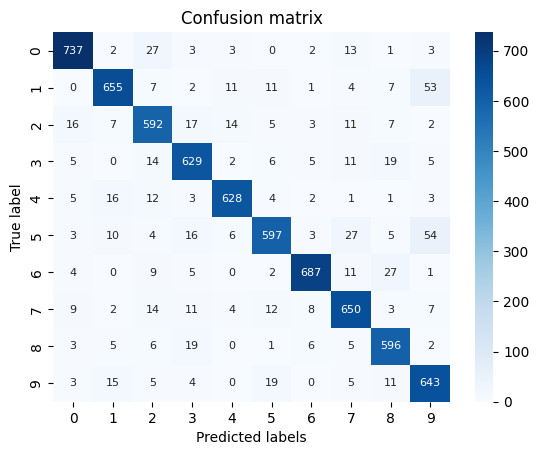

In [149]:
import seaborn as sns
import matplotlib.pyplot as plt


# ploting the confusion matrix
# we use seaborn to plot the confusion matrix
# we display the number of cases in each cell of the matrix

sns.heatmap(confusion_matrix, annot=True, annot_kws={"size": 8}, fmt='g', cmap='Blues')

plt.xlabel("Predicted labels")
plt.ylabel("True label")

plt.title("Confusion matrix")

plt.show()


From the confusion matrix we can clearly see that one of the caveats of this model is that it confuses 9 with 1 or 5.
However, this error is only visible when the real number is 9. Other than that the we don't catch any drastic anomalies, rest of the errors are more or less evenly distributed.